# FB Prophet Modeling

This notebook attempts to recreate overall model using FB Prophet time series toolkit

In [18]:
# Standard import. Having environment issues with Plotly

import pandas as pd
import numpy as np
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import matplotlib

In [4]:
# Import util file

from util import dickey_fuller, process_neighborhood, report_metrics, plot_results

In [7]:
# Import clean dataset

df_citibike = pd.read_csv('./../clean_data/final_clean_ridership.csv', low_memory=False)

In [8]:
# Convert starttime to date and set as index

df_citibike['starttime'] = pd.to_datetime(df_citibike['starttime'])

df_citibike.set_index('starttime', inplace=True)

In [9]:
# Create the daily file

daily_ridership = df_citibike[['ride_count']].resample('1D').sum()

# Backfill dates with 0 rides (logic for this change in EDA notebook)
daily_ridership['ride_count'] = daily_ridership['ride_count'].replace(to_replace=0, method='bfill')

In [10]:
# Define Train / Test split time

test_start = '2020-11-01'

In [15]:
# Convert daily to weekly for modeling

weekly_ridership = daily_ridership.resample('W-SUN').sum()

weekly_ridership['future'] = (weekly_ridership.index >= test_start).astype('int')

# Log transform ridership

weekly_ridership['ride_count_log'] = weekly_ridership['ride_count'].apply(lambda x: np.log(x))

In [16]:
# Create train test splits

train_weekly = weekly_ridership[weekly_ridership['future'] == 0]['ride_count_log']
test_weekly = weekly_ridership[weekly_ridership['future'] == 1]['ride_count_log']

In [44]:
# Instantiate a Prophet object

m = Prophet(weekly_seasonality=True)

In [35]:
# Create DataFrame of the training data with columns needed for Prophet

train_df = train_weekly.to_frame().reset_index()

train_df.rename(columns={'starttime': 'ds', 'ride_count_log': 'y'}, inplace=True)

# Repeat for test

test_df = train_weekly.to_frame().reset_index()

test_df.rename(columns={'starttime': 'ds', 'ride_count_log': 'y'}, inplace=True)

In [36]:
# Sense check output

train_df.head()

,ds,y
0,2013-06-02,10.114275
1,2013-06-09,11.426899
2,2013-06-16,11.546264
3,2013-06-23,12.040437
4,2013-06-30,12.146275


In [45]:
# Fit on the training data

m.fit(train_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1346.39    0.00030886       125.057     0.05639           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       1346.39   3.16868e-05       110.284   2.534e-07       0.001      168  LS failed, Hessian reset 
     199       1347.78     0.0012106       84.6678        1.43           1      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1348.9    0.00068587       99.3731      0.4013      0.6274      429   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1349.47   4.25266e-06       68.6651      0.2351      0.2351      559   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     427       1349.48   0.000117295       192.466   1.254e-06       0.001      6

In [51]:
# Create "future" df

future = m.make_future_dataframe(freq='W', periods=52)
future.tail()

,ds
434,2021-09-26
435,2021-10-03
436,2021-10-10
437,2021-10-17
438,2021-10-24


In [52]:
# Store forecast in the new dataframe

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
434,2021-09-26,13.142649,12.825271,13.472343
435,2021-10-03,13.109958,12.796459,13.444420
436,2021-10-10,13.037553,12.727549,13.332938
437,2021-10-17,12.980473,12.636956,13.293694
438,2021-10-24,12.970031,12.679195,13.281274


In [61]:
preds = forecast[['ds', 'yhat']]

preds['ds'] = pd.to_datetime(forecast['ds'])

preds.set_index('ds', inplace=True)

preds = preds[preds.index > '10/31/2020']

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_81926/1283687508.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(forecast['ds'])


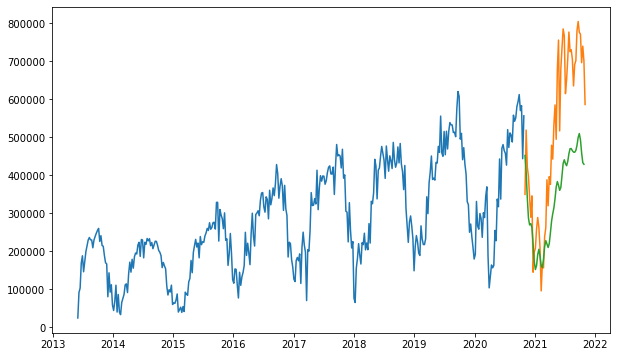

In [62]:
# Plot the predictions

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(np.exp(train_weekly))
ax.plot(np.exp(test_weekly))
ax.plot(np.exp(preds));

Conclusions: the COVID downturn is messing with the predictions. Let's see if we can't add in controls for this.